## Haxby data set:
Haxby is a high-quality block-design fMRI dataset from a study on face & object representation in the human ventral temporal cortex (This cortex is involved in the high-level visual processing of complex stimuli). It consists of 6 subjects with 12 runs per subject. In this experiment during each run, the subjects passively viewed greyscale images of 8 object categories, grouped in 24s blocks separated by rest periods. Each image was shown for 500ms and was followed by a 1500ms inter-stimulus interval.

## Project Goal
For this project i am trying machine learning and deep learning methods to learning about barin decoding and predicting which object category the subject saw by analyzing the fMRI activity recorded masks of the ventral stream.

In [1]:
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from nilearn.plotting import plot_anat, show, plot_stat_map, plot_matrix
from nilearn import datasets, plotting, image
from nilearn.image import mean_img, get_data 
from nilearn.input_data import NiftiMasker
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier,  RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import tree

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
#%matplotlib inline
#%load_ext memory_profiler

## Dataset

In [3]:
# If we don't define which subject by default 2nd subject will be fetched.
haxby_ds = datasets.fetch_haxby(subjects=[4], fetch_stimuli=True)

len(haxby_ds.func)

1

In [4]:
# Read the data documentation
print(haxby_ds['description'].decode('utf-8'))

Haxby 2001 results


Notes
-----
Results from a classical fMRI study that investigated the differences between
the neural correlates of face versus object processing in the ventral visual
stream. Face and object stimuli showed widely distributed and overlapping
response patterns.

Content
-------
The "simple" dataset includes
    :'func': Nifti images with bold data
    :'session_target': Text file containing session data
    :'mask': Nifti images with employed mask
    :'session': Text file with condition labels


The full dataset additionally includes
    :'anat': Nifti images with anatomical image
    :'func': Nifti images with bold data
    :'mask_vt': Nifti images with mask for ventral visual/temporal cortex
    :'mask_face': Nifti images with face-reponsive brain regions
    :'mask_house': Nifti images with house-reponsive brain regions
    :'mask_face_little': Spatially more constrained version of the above
    :'mask_house_little': Spatially more constrained version of the abov

In [5]:
# Look inside the data
haxby_ds.keys()

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description', 'stimuli'])

In [6]:
haxby_ds.session_target

['/home/srastegarnia/nilearn_data/haxby2001/subj4/labels.txt']

In [7]:
mask_file = haxby_ds.mask
labels = haxby_ds.session_target[0]
mask_vt_file = haxby_ds.mask_vt[0]
mask_face_file = haxby_ds.mask_face[0]

# 'func' is a list of filenames: one for each subject
func_file = haxby_ds.func[0]

# Load the behavioral data that I will predict
beh_label = pd.read_csv(haxby_ds.session_target[0], sep=" ")

# Extract tags indicating to which acquisition run a tag belongs
session = beh_label['chunks']

# Preparing the data (Load target information as string and give a numerical identifier to each)
y = beh_label['labels']

# Identify the resting state
nonrest_task_mask = (y != 'rest')

# Remove the resting state and find names of remaining active labels
categories = y[nonrest_task_mask].unique()
#session = session[nonrest_task_mask]

# Get the labels of the numerical conditions represented by the vector y
unique_conditions, order = np.unique(categories, return_index=True)

# Sort the conditions by the order of appearance
unique_conditions = unique_conditions[np.argsort(order)]

# Extract tags indicating to which acquisition run a tag belongs
session_labels = beh_label['chunks'][nonrest_task_mask]

In [8]:
# Print basic information on the dataset
print('Functional nifti images are located at: %s' % haxby_ds.func[0])
print('Mask nifti image (3D) is located at:  %s' % haxby_ds.mask)
print('First subject functional nifti images (4D) are at: %s' %func_file)  # 4D data

Functional nifti images are located at: /home/srastegarnia/nilearn_data/haxby2001/subj4/bold.nii.gz
Mask nifti image (3D) is located at:  /home/srastegarnia/nilearn_data/haxby2001/mask.nii.gz
First subject functional nifti images (4D) are at: /home/srastegarnia/nilearn_data/haxby2001/subj4/bold.nii.gz


In [9]:
# Checkout the confounds of the data
session_target = pd.read_csv(haxby_ds['session_target'][0], sep='\t')

session_target.head()

,labels chunks
0,rest 0
1,rest 0
2,rest 0
3,rest 0
4,rest 0


## Preparing the fMRI data (smooth and apply the mask)

In [10]:
# Standardizing and smoothing the data
nifti_masker = NiftiMasker(mask_img=mask_file, standardize=True, sessions=session,  smoothing_fwhm=4,
                           memory="nilearn_cache", memory_level=1)

X = nifti_masker.fit_transform(func_file)


## Plot Haxby masks

In [11]:
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)
fmri_masked = masker.fit_transform(func_file)

In [12]:
# The variable “fmri_masked” is a numpy array
print(fmri_masked)

[[-2.6038213  -4.024481    0.82268804 ... -1.3077999  -0.76046395
  -0.80006576]
 [-2.6749918  -4.101693    1.2567352  ... -1.4760997  -0.8379458
  -0.6758426 ]
 [-3.1494625  -3.5612085   1.0739785  ... -1.1395003  -1.0962186
  -0.80006576]
 ...
 [-1.4176446  -0.7429663  -1.5303041  ... -0.992238   -0.5538457
  -0.9656967 ]
 [-1.038068   -1.6502086  -1.6902162  ... -0.5083763  -0.81211853
  -0.75865805]
 [-0.7296622  -0.91669357 -1.484615   ...  0.5645344   0.24679996
  -0.1789499 ]]


In [13]:
print(fmri_masked.shape)

(1452, 675)


## Converting the Mask to a Matrix

In [14]:
# load bold image into memory as a nibabel image
func = nib.load(func_file)

# load mask image into memory as a nibabel image
mask = nib.load(mask_file) 

# get the physical data of the mask (3D matrix of voxels)
mask_data = mask.get_data() 

print(func.shape)
print(mask.shape) 
print(len(mask_data[mask_data==1]))

(40, 64, 64, 1452)
(40, 64, 64)
39912


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


In [15]:
# Create the masker object 
masker = NiftiMasker(mask_img=mask_file, standardize=True)

# Create a numpy matrix from the BOLD data, using the mask for the transformation
func_masked = masker.fit_transform(func_file)

# View the dimensions of the matrix. The shape represents the number of time-stamps by the number of voxels in the mask. 
print(func_masked.shape)

(1452, 39912)


In [16]:
# Viewing the numerical values of the matrix
print(func_masked)

[[ 1.851505   -1.1370772  -1.029912   ... -0.97751945 -0.9890595
  -0.9778365 ]
 [ 1.6732124  -1.1370772  -1.029912   ... -0.97751945 -0.9890595
  -0.9778365 ]
 [-1.0308924  -1.1370772  -1.029912   ... -0.97751945  1.6580281
   1.1377147 ]
 ...
 [ 0.12800965  0.75440264  0.08345481 ... -0.97751945 -0.9890595
  -0.9778365 ]
 [ 0.6331721   0.8390958   0.32418278 ... -0.97751945 -0.9890595
  -0.9778365 ]
 [ 0.5143103   1.064944   -0.12718217 ... -0.97751945 -0.9890595
  -0.9778365 ]]


In [17]:
# Load the labels from a csv into an array using pandas
stimuli = pd.read_csv(labels, sep=' ')

In [18]:
# View the dimensions of the matrix
print(stimuli.shape)

# Viewing the values of the matrix
print(stimuli)

(1452, 2)
     labels  chunks
0      rest       0
1      rest       0
2      rest       0
3      rest       0
4      rest       0
...     ...     ...
1447   rest      11
1448   rest      11
1449   rest      11
1450   rest      11
1451   rest      11

[1452 rows x 2 columns]


In [19]:
targets = stimuli['labels']
print(targets)

0       rest
1       rest
2       rest
3       rest
4       rest
        ... 
1447    rest
1448    rest
1449    rest
1450    rest
1451    rest
Name: labels, Length: 1452, dtype: object


In [20]:
targets_mask = targets.isin(['face', 'cat'])
print(targets_mask)

0       False
1       False
2       False
3       False
4       False
        ...  
1447    False
1448    False
1449    False
1450    False
1451    False
Name: labels, Length: 1452, dtype: bool


In [21]:
func_masked = func_masked[targets_mask]
func_masked.shape

(216, 39912)

In [22]:
targets_masked = targets[targets_mask]

print(targets_masked.shape)
print(targets_masked)

(216,)
6       face
7       face
8       face
9       face
10      face
        ... 
1370     cat
1371     cat
1372     cat
1373     cat
1374     cat
Name: labels, Length: 216, dtype: object


# ML Models

## Decoding with ANOVA + SVM: face vs house in the Haxby dataset

In [23]:
# Restrict the analysis to faces and places
condition_mask = beh_label['labels'].isin(['face', 'house'])
conditions_f_h = y[condition_mask]

# Confirm that I now have 2 conditions
print(conditions_f_h.unique())

session_f_h = beh_label[condition_mask].to_records(index=False)
print(session_f_h.dtype.names)

['face' 'house']
('labels', 'chunks')


In [24]:
# Apply our condition_mask to fMRI data
X_f_h = X[condition_mask]

In [25]:
#Build the decoder

#Define the prediction function to be used. Here I am using a Support Vector Classification, with a linear kernel
svc = SVC(kernel='linear')

# Define the dimension reduction to be used. (keep 5% of voxels)
feature_selection = SelectPercentile(f_classif, percentile=5)

# I have SVC classifier and our feature selection (SelectPercentile),then plug them together in a *pipeline*:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

In [26]:
# Fit the decoder and predict
anova_svc.fit(X_f_h, conditions_f_h)
y_pred = anova_svc.predict(X_f_h)

In [27]:
# Obtain prediction scores via cross validation

# Define the cross-validation scheme used for validation, using LeaveOneGroupOut cross-validation.
cv = LeaveOneGroupOut()

# Compute the prediction accuracy for the different folds (i.e. session)
cv_scores = cross_val_score(anova_svc, X_f_h, conditions_f_h, cv=cv, groups=session_f_h)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chance level: %f" % (classification_accuracy, 1. / len(conditions_f_h.unique())))

Classification accuracy: 0.9769 / Chance level: 0.500000


Visualizing the results:

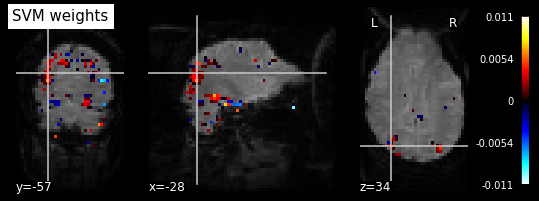

In [28]:
# Look at the SVC’s discriminating weights
coef = svc.coef_
# reverse feature selection
coef = feature_selection.inverse_transform(coef)
# reverse masking
weight_img = masker.inverse_transform(coef)

# Use the mean image as a background to avoid relying on anatomical data
mean_img = image.mean_img(func_file)

# Create the figure
plot_stat_map(weight_img, mean_img, title='SVM weights')

# Save the results as a Nifti file
#weight_img.to_file('haxby_face_vs_house.nii')

## ROI-based decoding analysis
In this section, I am looking at decoding accuracy for different objects in three different masks: the full ventral stream (mask_vt), the house selective areas (mask_house), and the face-selective areas (mask_face), that have been defined via a standard General Linear Model (GLM) based analysis.

In [29]:
# extract tags indicating to which acquisition run a tag belongs
session_labels = beh_label["chunks"][nonrest_task_mask]

In [30]:
# The classifier: a support vector classifier
classifier = SVC(C=1., kernel="linear")

# A classifier to set the chance level
dummy_classifier = DummyClassifier()

# Make a data splitting object for cross validation
cv = LeaveOneGroupOut()

mask_names = ['mask_vt', 'mask_face', 'mask_house']

mask_scores = {}
mask_chance_scores = {}

for mask_name in mask_names:
    print("Working on mask %s" % mask_name)
    
    # Standardizing
    mask_filename = haxby_ds[mask_name][0]
    masker = NiftiMasker(mask_img=mask_filename, standardize=True)
    masked_timecourses = masker.fit_transform(func_file)[nonrest_task_mask]

    mask_scores[mask_name] = {}
    mask_chance_scores[mask_name] = {}

    for category in categories:
        print("Processing %s %s" % (mask_name, category))
        classification_target = (y[nonrest_task_mask] == category)
        mask_scores[mask_name][category] = cross_val_score(
            classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="roc_auc",
        )

        mask_chance_scores[mask_name][category] = cross_val_score(
            dummy_classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="roc_auc",
        )

        print("Scores: %1.2f +- %1.2f" % (
            mask_scores[mask_name][category].mean(),
            mask_scores[mask_name][category].std()))

Working on mask mask_vt
Processing mask_vt face


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.99 +- 0.01
Processing mask_vt chair


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.84 +- 0.14
Processing mask_vt scissors


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.85 +- 0.10
Processing mask_vt shoe


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.85 +- 0.10
Processing mask_vt scrambledpix


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.98 +- 0.03
Processing mask_vt house


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.99 +- 0.02
Processing mask_vt cat


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.85 +- 0.16
Processing mask_vt bottle


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.72 +- 0.21
Working on mask mask_face
Processing mask_face face


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.95 +- 0.05
Processing mask_face chair


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.65 +- 0.14
Processing mask_face scissors


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.73 +- 0.15
Processing mask_face shoe


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.71 +- 0.17
Processing mask_face scrambledpix


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.91 +- 0.07
Processing mask_face house


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.88 +- 0.10
Processing mask_face cat


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.76 +- 0.17
Processing mask_face bottle


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.51 +- 0.20
Working on mask mask_house
Processing mask_house face


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.95 +- 0.04
Processing mask_house chair


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.80 +- 0.12
Processing mask_house scissors


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.67 +- 0.17
Processing mask_house shoe


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.77 +- 0.08
Processing mask_house scrambledpix


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.96 +- 0.02
Processing mask_house house


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.98 +- 0.02
Processing mask_house cat


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.63 +- 0.18
Processing mask_house bottle
Scores: 0.62 +- 0.14


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

## Different multi-class strategies
I compare one vs all and one vs one multi-class strategies: the overall cross-validated accuracy and the confusion matrix.

In [31]:
# Build the decoders, using scikit-learn

svc_ovo = OneVsOneClassifier(Pipeline([
    ('anova', SelectKBest(f_classif, k=500)),
    ('svc', SVC(kernel='linear'))
]))

svc_ova = OneVsRestClassifier(Pipeline([
    ('anova', SelectKBest(f_classif, k=500)),
    ('svc', SVC(kernel='linear'))
]))

In [32]:
# Remove the "rest" condition
y = y[nonrest_task_mask]
X = X[nonrest_task_mask]

cv_scores_ovo = cross_val_score(svc_ovo, X, y, cv=5, verbose=1)

cv_scores_ova = cross_val_score(svc_ova, X, y, cv=5, verbose=1)

print('OvO:', cv_scores_ovo.mean())
print('OvA:', cv_scores_ova.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


OvO: 0.5369538916521037
OvA: 0.6007057400188197


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.1s finished


Text(0.5, 1.0, 'Prediction: accuracy score')

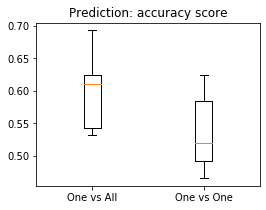

In [33]:
# Plot barplots of the prediction scores

plt.figure(figsize=(4, 3))
plt.boxplot([cv_scores_ova, cv_scores_ovo])
plt.xticks([1, 2], ['One vs All', 'One vs One'])
plt.title('Prediction: accuracy score')

## Plot a confusion matrix:
To make sure that the system is not confusing two classes.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text yticklabel objects>)

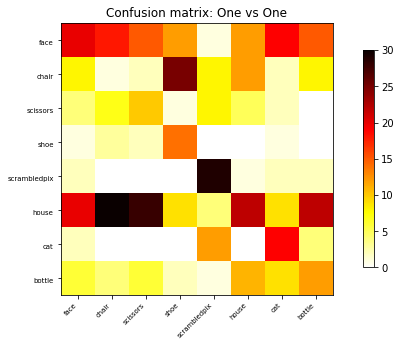

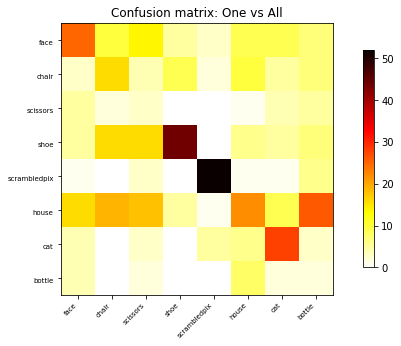

In [34]:
# I fit on the the first 10 sessions and plot a confusion matrix on the last 2 sessions
# Matrix rows represents the predicted class instances, columns represents actual class.

svc_ovo.fit(X[session_labels < 5], y[session_labels < 5])
y_pred_ovo = svc_ovo.predict(X[session_labels >= 5])

plot_matrix(confusion_matrix(y_pred_ovo, y[session_labels >= 5]),
            labels=unique_conditions, cmap='hot_r')
plt.title('Confusion matrix: One vs One')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

svc_ova.fit(X[session_labels < 5], y[session_labels < 5])
y_pred_ova = svc_ova.predict(X[session_labels >= 5])

plot_matrix(confusion_matrix(y_pred_ova, y[session_labels >= 5]),
            labels=unique_conditions, cmap='hot_r')
plt.title('Confusion matrix: One vs All')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text yticklabel objects>)

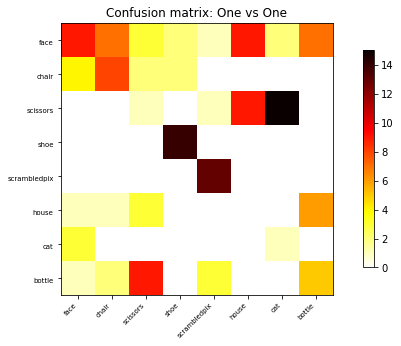

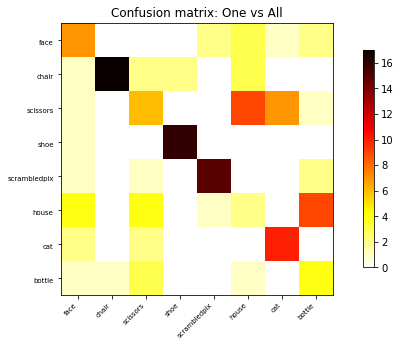

In [35]:
# Plotting the confusion matrix
svc_ovo.fit(X[session_labels < 10], y[session_labels < 10])
y_pred_ovo = svc_ovo.predict(X[session_labels >= 10])

plot_matrix(confusion_matrix(y_pred_ovo, y[session_labels >= 10]),
            labels=unique_conditions, cmap='hot_r')
plt.title('Confusion matrix: One vs One')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

svc_ova.fit(X[session_labels < 10], y[session_labels < 10])
y_pred_ova = svc_ova.predict(X[session_labels >= 10])

plot_matrix(confusion_matrix(y_pred_ova, y[session_labels >= 10]),
            labels=unique_conditions, cmap='hot_r')
plt.title('Confusion matrix: One vs All')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

### Classification

In [36]:
# Standardizing
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)
masked_timecourses = masker.fit_transform(func_file)[nonrest_task_mask]

In [37]:
# Support vector classifier
svm = SVC(C=1., kernel="linear")

# The logistic regression
#logistic = LogisticRegression(C=1., penalty="l1", solver='liblinear')
logistic_50 = LogisticRegression(C=50., penalty="l1", solver='liblinear')
#logistic_l2 = LogisticRegression(C=1., penalty="l2", solver='liblinear')

# Cross-validated versions of these classifiers
svm_cv = GridSearchCV(SVC(C=1., kernel="linear"),
                      param_grid={'C': [.1, 1., 10., 100.]},
                      scoring='f1', n_jobs=1, cv=3, iid=False)

logistic_cv = GridSearchCV(
        LogisticRegression(C=1., penalty="l1", solver='liblinear'),
        param_grid={'C': [.1, 1., 10., 100.]},
        scoring='f1', cv=3, iid=False,
        )

# The ridge classifier has a specific 'CV' object that can set it's parameters faster than using a GridSearchCV
ridge = RidgeClassifier()
ridge_cv = RidgeClassifierCV()

# A dictionary, to hold all our classifiers
classifiers = {'SVC': svm,
               'SVC cv': svm_cv,
               'log l1 50': logistic_50,
               'log l1 cv': logistic_cv,
               'ridge': ridge,
               'ridge cv': ridge_cv
               }

Prediction scores:

In [38]:
# Make a data splitting object for cross validation
cv = LeaveOneGroupOut()

classifiers_scores = {}

for classifier_name, classifier in sorted(classifiers.items()):
    classifiers_scores[classifier_name] = {}
    print(70 * '_')

    for category in categories:
        classification_target = y[nonrest_task_mask].isin([category])
        t0 = time.time()
        classifiers_scores[classifier_name][category] = cross_val_score(
            classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="f1",
        )

        print(
            "%10s: %14s -- scores: %1.2f +- %1.2f, time %.2fs" %
            (
                classifier_name,
                category,
                classifiers_scores[classifier_name][category].mean(),
                classifiers_scores[classifier_name][category].std(),
                time.time() - t0,
            ),
        )

______________________________________________________________________
       SVC:           face -- scores: 0.82 +- 0.12, time 2.50s
       SVC:          chair -- scores: 0.18 +- 0.21, time 3.24s
       SVC:       scissors -- scores: 0.35 +- 0.24, time 3.42s
       SVC:           shoe -- scores: 0.36 +- 0.22, time 3.74s
       SVC:   scrambledpix -- scores: 0.70 +- 0.19, time 2.86s
       SVC:          house -- scores: 0.80 +- 0.21, time 1.72s
       SVC:            cat -- scores: 0.33 +- 0.24, time 3.18s
       SVC:         bottle -- scores: 0.22 +- 0.22, time 3.44s
______________________________________________________________________


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:           face -- scores: 0.82 +- 0.12, time 15.92s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:          chair -- scores: 0.18 +- 0.21, time 28.64s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:       scissors -- scores: 0.35 +- 0.24, time 27.37s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:           shoe -- scores: 0.36 +- 0.22, time 28.95s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:   scrambledpix -- scores: 0.70 +- 0.19, time 20.39s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:          house -- scores: 0.80 +- 0.21, time 14.62s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:            cat -- scores: 0.33 +- 0.24, time 26.62s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:         bottle -- scores: 0.22 +- 0.22, time 28.16s
______________________________________________________________________
 log l1 50:           face -- scores: 0.78 +- 0.17, time 1.12s
 log l1 50:          chair -- scores: 0.26 +- 0.23, time 2.12s
 log l1 50:       scissors -- scores: 0.39 +- 0.20, time 2.11s
 log l1 50:           shoe -- scores: 0.44 +- 0.21, time 2.34s
 log l1 50:   scrambledpix -- scores: 0.60 +- 0.15, time 1.14s
 log l1 50:          house -- scores: 0.83 +- 0.20, time 0.88s
 log l1 50:            cat -- scores: 0.32 +- 0.18, time 2.74s
 log l1 50:         bottle -- scores: 0.26 +- 0.16, time 3.19s
______________________________________________________________________


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:           face -- scores: 0.83 +- 0.09, time 5.92s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:          chair -- scores: 0.25 +- 0.25, time 10.06s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:       scissors -- scores: 0.39 +- 0.19, time 10.43s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:           shoe -- scores: 0.36 +- 0.26, time 10.20s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:   scrambledpix -- scores: 0.58 +- 0.24, time 6.93s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:          house -- scores: 0.80 +- 0.20, time 5.83s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:            cat -- scores: 0.28 +- 0.17, time 10.92s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:         bottle -- scores: 0.24 +- 0.16, time 12.67s
______________________________________________________________________
     ridge:           face -- scores: 0.64 +- 0.19, time 0.36s
     ridge:          chair -- scores: 0.32 +- 0.13, time 0.20s
     ridge:       scissors -- scores: 0.36 +- 0.13, time 0.21s
     ridge:           shoe -- scores: 0.25 +- 0.19, time 0.19s
     ridge:   scrambledpix -- scores: 0.51 +- 0.17, time 0.21s
     ridge:          house -- scores: 0.75 +- 0.13, time 0.20s
     ridge:            cat -- scores: 0.28 +- 0.10, time 0.22s
     ridge:         bottle -- scores: 0.20 +- 0.13, time 0.20s
______________________________________________________________________
  ridge cv:           face -- scores: 0.82 +- 0.13, time 2.22s
  ridge cv:          chair -- scores: 0.27 +- 0.17, time 2.13s
  ridge cv:       scissors -- scores: 0.42 +- 0.10, time 2.07s
  ridge cv:           shoe -- scores: 0.31 +- 0.24, time 2.03s
  ridge cv:   scrambledpix -- scores: 

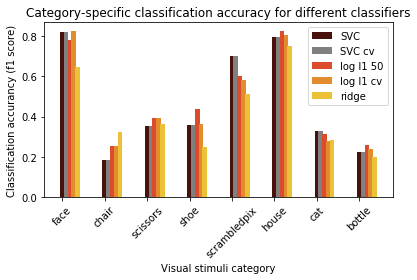

In [39]:
# Make a rudimentary diagram

plt.figure()

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, classifier_name in zip(
        ['#48110C', '#808080', '#DB4C2C', '#E38C2D', '#EBC137'],
        sorted(classifiers)):
    score_means = [classifiers_scores[classifier_name][category].mean()
                   for category in categories]
    plt.bar(tick_position, score_means, label=classifier_name, width=.11, color=color)
    tick_position = tick_position + .09

plt.ylabel('Classification accurancy (f1 score)')
plt.xlabel('Visual stimuli category')
plt.ylim(ymin=0)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Category-specific classification accuracy for different classifiers')
plt.tight_layout()

/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can b

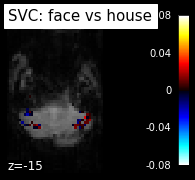

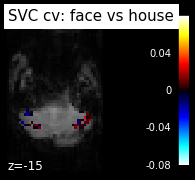

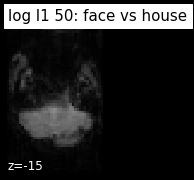

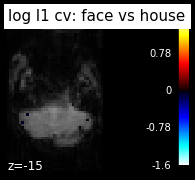

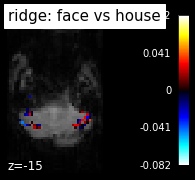

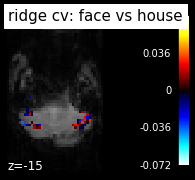

In [40]:
# Plot the face vs house map for the different classifiers

mean_epi_img = image.mean_img(func_file)

# Restrict the decoding to face vs house
condition_mask = y.isin(['face', 'house'])
masked_timecourses = masked_timecourses[
    condition_mask[nonrest_task_mask]]
y_f = (y[condition_mask] == 'face')

# Transform the stimuli to binary values
y_f.astype(np.int)

for classifier_name, classifier in sorted(classifiers.items()):
    classifier.fit(masked_timecourses, y_f)

    if hasattr(classifier, 'coef_'):
        weights = classifier.coef_[0]
    elif hasattr(classifier, 'best_estimator_'):
        weights = classifier.best_estimator_.coef_[0]
    else:
        continue
    weight_img = masker.inverse_transform(weights)
    weight_map = get_data(weight_img)
    threshold = np.max(np.abs(weight_map)) * 1e-3
    plot_stat_map(weight_img, bg_img=mean_epi_img, display_mode='z', cut_coords=[-15],
                  threshold=threshold, title='%s: face vs house' % classifier_name)